# Contrastive Analysis

In [26]:
from datasets import load_from_disk
import inseq
from inseq.data.aggregator import AggregatorPipeline, SubwordAggregator, SequenceAttributionAggregator
from iwslt import preprocess
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

## Load Dataset

In [2]:
ds = load_from_disk("../data/iwslt_labelled")

In [3]:
print(ds)

Dataset({
    features: ['informal_ko', 'informal_de', 'formal_ko', 'formal_de', 'en', 'category', 'upos_tags_informal_ko', 'pos_tags_informal_ko', 'ws_tokens_informal_ko', 'sent_ids_informal_ko', 'form_map_informal_ko', 'upos_tags_informal_de', 'pos_tags_informal_de', 'ws_tokens_informal_de', 'sent_ids_informal_de', 'form_map_informal_de', 'upos_tags_formal_ko', 'pos_tags_formal_ko', 'ws_tokens_formal_ko', 'sent_ids_formal_ko', 'form_map_formal_ko', 'upos_tags_formal_de', 'pos_tags_formal_de', 'ws_tokens_formal_de', 'sent_ids_formal_de', 'form_map_formal_de'],
    num_rows: 200
})


In [4]:
print(ds["ws_tokens_formal_de"][2])
print(ds["ws_tokens_informal_de"][2])

['Sie', 'wissen', ',', 'was', 'ich', 'meine', ',', 'Ich', 'denke', 'wir', 'sind', 'eine', 'Familie', '.', 'Familie', 'ist', 'alles', ',', 'was', 'wir', 'haben', ',', 'die', 'einzigen', 'Menschen', ',', 'die', 'sich', 'um', 'dich', 'kümmern', '.']
['Du', 'weißt', ',', 'was', 'ich', 'meine', ',', 'Ich', 'denke', 'wir', 'sind', 'eine', 'Familie', '.', 'Familie', 'ist', 'alles', ',', 'was', 'wir', 'haben', ',', 'die', 'einzigen', 'Menschen', ',', 'die', 'sich', 'um', 'dich', 'kümmern', '.']


In [5]:
model_de_ko = inseq.load_model(
    "facebook/mbart-large-50-many-to-many-mmt",
    "input_x_gradient",
    tokenizer_kwargs={"src_lang": "de_DE", "tgt_lang": "ko_KR"},
)

In [6]:
model_ko_de = inseq.load_model(
    "facebook/mbart-large-50-many-to-many-mmt",
    "input_x_gradient",
    tokenizer_kwargs={"src_lang": "ko_KR", "tgt_lang": "de_DE"},
)


In [7]:
def filter_sentences(example: dict, model: inseq.AttributionModel, formal_col: str, informal_col: str) -> dict:
    formal = model.encode(example[formal_col], as_targets=True)
    informal = model.encode(example[informal_col], as_targets=True)

    if len(formal.input_tokens[0]) == len(informal.input_tokens[0]):
        for i in range(len(formal.input_tokens[0])):
            if formal.input_tokens[0][i] != informal.input_tokens[0][i]:
                return True

    return False


In [8]:
de_ko_matching = ds.filter(filter_sentences, fn_kwargs={"model":model_de_ko, "formal_col":"formal_ko", "informal_col":"informal_ko"})

Loading cached processed dataset at /Users/lsickert/Repositories/rude-nmt/data/iwslt_labelled/cache-bb2499859efe1c11.arrow


In [9]:
print(de_ko_matching)

Dataset({
    features: ['informal_ko', 'informal_de', 'formal_ko', 'formal_de', 'en', 'category', 'upos_tags_informal_ko', 'pos_tags_informal_ko', 'ws_tokens_informal_ko', 'sent_ids_informal_ko', 'form_map_informal_ko', 'upos_tags_informal_de', 'pos_tags_informal_de', 'ws_tokens_informal_de', 'sent_ids_informal_de', 'form_map_informal_de', 'upos_tags_formal_ko', 'pos_tags_formal_ko', 'ws_tokens_formal_ko', 'sent_ids_formal_ko', 'form_map_formal_ko', 'upos_tags_formal_de', 'pos_tags_formal_de', 'ws_tokens_formal_de', 'sent_ids_formal_de', 'form_map_formal_de'],
    num_rows: 57
})


In [10]:
ko_de_matching = ds.filter(filter_sentences, fn_kwargs={"model":model_ko_de, "formal_col":"formal_de", "informal_col":"informal_de"})

Loading cached processed dataset at /Users/lsickert/Repositories/rude-nmt/data/iwslt_labelled/cache-b28deb952a89eb67.arrow


In [11]:
print(ko_de_matching)

Dataset({
    features: ['informal_ko', 'informal_de', 'formal_ko', 'formal_de', 'en', 'category', 'upos_tags_informal_ko', 'pos_tags_informal_ko', 'ws_tokens_informal_ko', 'sent_ids_informal_ko', 'form_map_informal_ko', 'upos_tags_informal_de', 'pos_tags_informal_de', 'ws_tokens_informal_de', 'sent_ids_informal_de', 'form_map_informal_de', 'upos_tags_formal_ko', 'pos_tags_formal_ko', 'ws_tokens_formal_ko', 'sent_ids_formal_ko', 'form_map_formal_ko', 'upos_tags_formal_de', 'pos_tags_formal_de', 'ws_tokens_formal_de', 'sent_ids_formal_de', 'form_map_formal_de'],
    num_rows: 72
})


## Perform Attributions

In [12]:
# Pre-compute ids and attention map for the contrastive target
contrast = model_de_ko.encode(de_ko_matching["formal_ko"][0], as_targets=True)

out = model_de_ko.attribute(
    input_texts=de_ko_matching["informal_de"][0],
    generated_texts=de_ko_matching["informal_ko"][0],
    attributed_fn="contrast_prob_diff",
    step_scores=["contrast_prob_diff", "probability"],
    contrast_ids=contrast.input_ids,
    contrast_attention_mask=contrast.attention_mask,
)

out.weight_attributions("contrast_prob_diff")
out.show()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Attributing with input_x_gradient...: 100%|██████████| 33/33 [00:43<00:00,  1.36s/it]
/Users/lsickert/Repositories/rude-nmt/.venv/lib/python3.10/site-packages/inseq/data/attribution.py:275: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3281.)
  step_scores = self.step_scores[step_fn_id].T.unsqueeze(1)


,ko_KR,▁가끔,▁한,▁번,씩,▁만,일,▁내가,▁찾고,▁있는,▁어떤,▁특별한,▁것이,▁있으면,",",▁예를,▁들어,▁맛있는,▁생,선,이나,▁냉,동,▁안,▁된,▁물건,이,▁있으면,▁사,지,.,</s>
de_DE,,,,,,,,-0.009,0.001,0.0,-0.0,-0.0,0.0,0.0,0.0,0.001,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.012,-0.046,-0.001
▁Ich,,,,,,,,-0.005,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.011,-0.019,-0.0
▁kau,,,,,,,,-0.009,0.001,0.0,-0.0,-0.0,0.0,0.0,0.0,0.001,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.001,0.0,-0.035,-0.053,-0.001
fe,,,,,,,,-0.004,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.014,-0.02,-0.0
▁es,,,,,,,,-0.003,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.007,-0.01,-0.0
▁ab,,,,,,,,-0.004,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.001,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.008,-0.014,-0.0
▁und,,,,,,,,-0.004,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.006,-0.012,-0.0
▁zu,,,,,,,,-0.004,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.001,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.008,-0.013,-0.0
",",,,,,,,,-0.003,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.004,-0.009,-0.0
▁wenn,,,,,,,,-0.007,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.009,-0.014,-0.0


In [14]:
print(out.sequence_attributions[0].step_scores["contrast_prob_diff"].tolist())

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.3000573515892029, 0.0248013436794281, 0.012335658073425293, -0.0002294890582561493, -0.0027141571044921875, 0.00330168753862381, 0.0024133995175361633, 0.00261051207780838, 0.023843377828598022, 0.005668938159942627, -3.9138307329267263e-05, -0.0010703876614570618, -0.0012835562229156494, -0.008774921298027039, -2.162711462005973e-05, 0.007328301668167114, 1.396331936120987e-05, -0.0012402348220348358, -8.548423647880554e-05, -0.000375404953956604, -0.01161058247089386, 0.0007273107767105103, -0.3304997682571411, -0.7738144397735596, -0.015991151332855225]


In [50]:
contrast_list_ko_informal = []

with tqdm(total=len(de_ko_matching)) as pbar:
    for example in de_ko_matching:
        contrast = model_de_ko.encode(example["formal_ko"], as_targets=True)

        out = model_de_ko.attribute(
            input_texts=example["informal_de"],
            generated_texts=example["informal_ko"],
            attributed_fn="contrast_prob_diff",
            step_scores=["contrast_prob_diff", "probability"],
            contrast_ids=contrast.input_ids,
            contrast_attention_mask=contrast.attention_mask,
            show_progress=False
        )

        out.weight_attributions("contrast_prob_diff")

        for attr in out.sequence_attributions:
            contr_prob_list = attr.step_scores["contrast_prob_diff"].tolist()
            for c in contr_prob_list:
                if c != 0.0:
                    contrast_list_ko_informal.append(c)
                    break
        
        pbar.update(1)

  0%|          | 0/57 [00:00<?, ?it/s]

In [ ]:
print(contrast_list_ko_informal)

[-0.3000573515892029, 0.002243595663458109, 0.0011301245540380478, -0.016541199758648872, -0.048298146575689316, -0.02367795631289482, 0.00021993639529682696, -0.01731019839644432, -0.03540828078985214, -0.1852007508277893, -0.0011473307386040688, -0.006525143980979919, -0.12692312896251678, -0.03795105963945389, -0.08889022469520569, -0.00858147069811821, -0.0005478111561387777, -0.21375185251235962, 0.2339704930782318, -0.020196583122015, 0.007986661978065968, -0.07822195440530777, -0.07460203021764755, -0.45354339480400085, -0.6192039251327515, -0.04973345994949341, -0.08706343173980713, -0.0815780907869339, 0.0025738936383277178, -0.005022453144192696, -0.011697234585881233, -0.011952141299843788, -0.0166920218616724, -0.20432545244693756, 0.005628904327750206, -0.05700824782252312, -0.10426707565784454, -0.08741825073957443, -0.09155115485191345, -0.010262750089168549, -0.2042873203754425, -0.05020624399185181, -0.09956809133291245, -0.008328414522111416, 0.14339274168014526, -0.1

(0.0, 57.0)

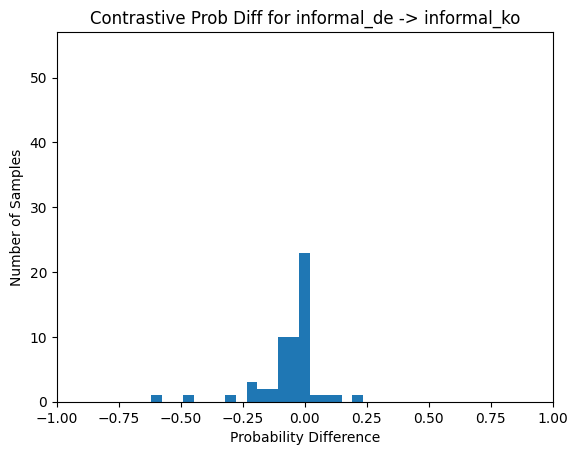

In [ ]:
fig, ax = plt.subplots()
ax.hist(contrast_list_ko_informal, bins="auto")
ax.set_title("Contrastive Prob Diff for informal_ko -> formal_ko")
ax.set_xlabel("Probability Difference")
ax.set_ylabel("Number of Samples")
ax.set_xlim(-1, 1)
ax.set_ylim(0, len(contrast_list_ko_informal))

In [ ]:
contrast_list_ko_formal = []

with tqdm(total=len(de_ko_matching)) as pbar:
    for example in de_ko_matching:
        contrast = model_de_ko.encode(example["informal_ko"], as_targets=True)

        out = model_de_ko.attribute(
            input_texts=example["formal_de"],
            generated_texts=example["formal_ko"],
            attributed_fn="contrast_prob_diff",
            step_scores=["contrast_prob_diff", "probability"],
            contrast_ids=contrast.input_ids,
            contrast_attention_mask=contrast.attention_mask,
            show_progress=False
        )

        out.weight_attributions("contrast_prob_diff")

        for attr in out.sequence_attributions:
            contr_prob_list = attr.step_scores["contrast_prob_diff"].tolist()
            for c in contr_prob_list:
                if c != 0.0:
                    contrast_list_ko_formal.append(c)
                    break
        
        pbar.update(1)

In [ ]:
fig, ax = plt.subplots()
ax.hist(contrast_list_ko_formal, bins="auto")
ax.set_title("Contrastive Prob Diff for formal_ko -> informal_ko")
ax.set_xlabel("Probability Difference")
ax.set_ylabel("Number of Samples")
ax.set_xlim(-1, 1)
ax.set_ylim(0, len(contrast_list_ko_formal))

In [49]:
# Pre-compute ids and attention map for the contrastive target
contrast = model_ko_de.encode(ko_de_matching["formal_de"][0], as_targets=True)

out = model_ko_de.attribute(
    input_texts=ko_de_matching["informal_ko"][0],
    generated_texts=ko_de_matching["informal_de"][0],
    attributed_fn="contrast_prob_diff",
    step_scores=["contrast_prob_diff", "probability"],
    contrast_ids=contrast.input_ids,
    contrast_attention_mask=contrast.attention_mask,
)

out.weight_attributions("contrast_prob_diff")
out.show()













































Attributing with input_x_gradient...: 100%|██████████| 44/44 [00:56<00:00,  1.31s/it]


,de_DE,▁Die,▁Mädchen,▁waren,▁hübsch,▁und,",",▁er,",",▁die,▁Mädchen,▁kamen,▁zuerst,",",und,▁sagen,▁ich,▁kenne,▁dich,▁aus,▁deinen,▁Facebook,bilder,n,",",▁als,▁ob,▁ich,▁es,▁wirklich,▁nicht,▁gew,us,st,▁hätte,",",▁Ja,",",▁das,▁ist,▁es,.,</s>
ko_KR,,,,,,,,,,,,,,,,,,,0.003,0.0,0.0,-0.0,0.001,0.0,-0.0,-0.0,0.0,0.001,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.001,0.0,-0.0,0.0,-0.0,0.001,0.0,0.0,-0.0
▁여자,,,,,,,,,,,,,,,,,,,0.001,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0
애,,,,,,,,,,,,,,,,,,,0.001,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0
들은,,,,,,,,,,,,,,,,,,,0.001,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.001,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0
▁예,,,,,,,,,,,,,,,,,,,0.001,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.001,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0
뻤,,,,,,,,,,,,,,,,,,,0.004,0.0,0.0,-0.0,0.002,0.0,-0.0,-0.0,0.0,0.002,0.0,-0.0,-0.001,-0.0,-0.0,-0.0,0.002,0.0,-0.0,0.0,-0.0,0.002,0.0,0.0,-0.0
고,,,,,,,,,,,,,,,,,,,0.001,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0
▁,,,,,,,,,,,,,,,,,,,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0
걔,,,,,,,,,,,,,,,,,,,0.007,0.001,0.0,-0.001,0.002,0.0,-0.0,-0.0,0.0,0.003,0.0,-0.0,-0.001,-0.0,-0.0,-0.0,0.004,0.0,-0.0,0.0,-0.0,0.002,0.001,0.0,-0.0
넨,,,,,,,,,,,,,,,,,,,0.005,0.0,0.0,-0.0,0.001,0.0,-0.0,-0.0,0.0,0.002,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.002,0.0,-0.0,0.0,-0.0,0.001,0.0,0.0,-0.0
